Initializing retail environment with user strategy: llm
Initializing tool-calling agent with model: gpt-4.1-nano
Tools info: [{'type': 'function', 'function': {'name': 'calculate', 'description': 'Calculate the result of a mathematical expression.', 'parameters': {'type': 'object', 'properties': {'expression': {'type': 'string', 'description': "The mathematical expression to calculate, such as '2 + 2'. The expression can contain numbers, operators (+, -, *, /), parentheses, and spaces."}}, 'required': ['expression']}}}, {'type': 'function', 'function': {'name': 'cancel_pending_order', 'description': "Cancel a pending order. If the order is already processed or delivered, it cannot be cancelled. The agent needs to explain the cancellation detail and ask for explicit user confirmation (yes/no) to proceed. If the user confirms, the order status will be changed to 'cancelled' and the payment will be refunded. The refund will be added to the user's gift card balance immediately if the payme

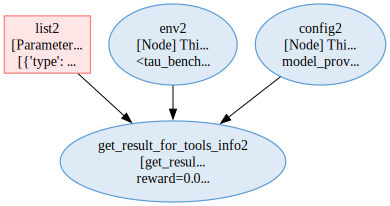

In [3]:
from tau_bench.envs import get_env
from tau_bench.agents.tool_calling_agent import ToolCallingAgent
from tau_bench.types import RunConfig
from tau_bench.envs.user import UserStrategy
# os.environ["TRACE_LITELLM_MODEL"] = "gemini/gemini-2.0-flash" # optional

import opto 
from opto.trace import bundle, node 
from opto.optimizers import OptoPrime 
from opto.trace.nodes import GRAPH 

def create_run_config():
    """Create a RunConfig object with default parameters from run.py"""
    return RunConfig(
        model_provider="openai",
        user_model_provider="gemini",
        model="gpt-4.1-nano",
        user_model="gemini-2.0-flash",
        num_trials=1,
        env="retail",
        agent_strategy="tool-calling",
        temperature=0.0,
        task_split="test",
        task_ids=[0],  # Select task with ID 1
        log_dir="results",
        max_concurrency=1,
        seed=10,
        shuffle=0,
        user_strategy="llm",
        few_shot_displays_path=None
    )

@bundle()
def get_result_for_tools_info(tools_info, env, config):
    "This function is used to get the result for an agent with a given tools_info. Specifically, tools_info is a node that contains information about the tools that the agent can use. It is used to create an agent that can use the tools to solve the task."
    agent = ToolCallingAgent(
        tools_info=tools_info,
        wiki=env.wiki,
        model=config.model,
        provider=config.model_provider,
        temperature=config.temperature
    )
    print(f"\nRunning task {config.task_ids[0]}")
    result = agent.solve(
        env=env,
        task_index=config.task_ids[0]  # Use the first (and only) task ID
    )
    return result


# Create configuration
config = create_run_config()

# Initialize environment
print(f"Initializing retail environment with user strategy: {config.user_strategy}")
env = get_env(
    config.env,
    user_strategy=config.user_strategy,
    user_model=config.user_model,
    user_provider=config.user_model_provider,
    task_split=config.task_split,
    task_index=config.task_ids[0]  # Use the first (and only) task ID
)

# Initialize agent
print(f"Initializing {config.agent_strategy} agent with model: {config.model}")

tools_info = node(env.tools_info, trainable=True)
print(f"Tools info: {tools_info.data}")


# agent = ToolCallingAgent(
#     tools_info=tools_info,
#     wiki=env.wiki,
#     model=config.model,
#     provider=config.model_provider,
#     temperature=config.temperature
# )

# Run the task

result = get_result_for_tools_info(tools_info, env, config)


print("\nTask Results:")
print(f"✅ Success" if result.data.reward == 1 else "❌ Failed")
print(f"Info: {result.data.info}")

optimizer = OptoPrime([tools_info])
feedback = result.data.info
optimizer.zero_feedback()
optimizer.backward(result, feedback,visualize=True,print_limit=10)
